In [8]:
import os
import numpy as np
import datetime
from tensorflow_core.python.keras.callbacks import EarlyStopping
from tensorflow_core.python.keras.utils import np_utils
from tensorflow_core.python.keras.models import Sequential
from tensorflow_core.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.python import math_ops
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow_core.python.keras.layers import Activation
from tensorflow_core.python.keras.utils import get_custom_objects   # 自定義gelu

np.random.seed(10)

In [9]:

sentence_type = 'SA1'
# sentence_type = 'SA2'
# sentence_type = 'SA'
# sentence_type = 'SX'

Tr_ver = 'orig_50_DR25_M_'
Te_ver = 'orig_50_DR25_M_'
# --------------------------------------------------
Tr_ver = 'pe_50_DR25_M_'
Te_ver = 'pe_50_DR25_M_'
# --------------------------------------------------
Tr_ver = 'pe_20_DR25_M_'
Te_ver = 'pe_20_DR25_M_'
# --------------------------------------------------
Tr_ver = 'pe_13_DR25_M_'
Te_ver = 'pe_13_DR25_M_'


Tr_ver += sentence_type + '_'
Te_ver += sentence_type + '_'

Tr_ver += '2_'
Te_ver += '2_'

shape = 50
shape = 20
shape = 13

now_path = r'D:\TIMITDIC_231101'
data_path = now_path + '_data_all_sentence'

Tr_CDF_path = os.path.join(data_path, 'TRAIN', 'cnn_dataset_librosa')
Te_CDF_path = os.path.join(data_path, 'TEST', 'cnn_dataset_librosa')

Tr_DS_path = os.path.join(Tr_CDF_path, 'mfcc', Tr_ver + 'SoundDataset.npz')

Te_DS_path = os.path.join(Te_CDF_path, 'mfcc', Te_ver + 'SoundDataset.npz')

In [10]:
Tr_DS = np.load(Tr_DS_path)
Te_DS = np.load(Te_DS_path)

train_value, train_label = Tr_DS['TrainValue'], Tr_DS['TrainLabel_class']
test_value, test_label = Te_DS['TestValue'], Te_DS['TestLabel_class']
# test_value, test_label, test_label2 = Te_DS['TestValue'], Te_DS['TestLabel_class'], Te_DS['TestLabel_type']

train_value_4D = train_value.reshape(train_value.shape[0], shape, shape, 1).astype('float32')
test_value_4D = test_value.reshape(test_value.shape[0], shape, shape, 1).astype('float32')

# 向量轉換為二進制(只有0和1)的矩陣類型
# 但train_label、test_label原先資料就都是0跟1?
train_label_OneHot = np_utils.to_categorical(train_label)
test_label_OneHot = np_utils.to_categorical(test_label)

In [11]:
class Davis( Activation ):    
    def __init__(self, activation, **kwargs):
        super(Davis, self).__init__(activation, **kwargs)
        self.__name__ = 'custom_gelu'

def custom_gelu(x):
    return 0.5 * x * (1 + math_ops.tanh(math_ops.sqrt(2 / np.pi) * (x + 0.044715 * math_ops.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Davis(custom_gelu)})
get_custom_objects().update({'Davis': (Activation)})

In [12]:
activation_cate = 'relu'
activation_cate = 'custom_gelu'
# activation_cate = 'sigmoid'
# activation_cate = 'elu'
# activation_cate = 'tanh'
kernel_size = 3

model = Sequential()
model.add(Conv2D(64, (kernel_size, kernel_size), input_shape=(shape, shape, 1), padding='same', activation=activation_cate))
model.add(Conv2D(64, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(Conv2D(128, (kernel_size, kernel_size), padding='same', activation=activation_cate))
# model.add(Conv2D(128, (3, 3), padding='same', activation='custom_gelu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='custom_gelu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation=activation_cate))
# model.add(Dropout(0.2))
model.add(Dense(128, activation=activation_cate))
model.add(Dropout(0.5))
model.add(Dense(32, activation=activation_cate))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [13]:
model.summary()
model.compile(loss='mean_squared_error',  # mean_squared_error, binary_crossentropy, categorical_crossentropy
              optimizer="adam",  # sgd, rmsprop, adam
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 128)        

In [14]:
# 創建一個早停法的回調函數
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
# early_stopping = EarlyStopping(monitor='val_acc', patience=100, restore_best_weights=True)

train_history=model.fit(x=train_value_4D,
                        y=train_label_OneHot,
                        validation_split=0.2,
                        epochs=500,
                        batch_size=300,
                        verbose=2,
                        callbacks=[early_stopping])
                        # )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 78 samples, validate on 20 samples
Epoch 1/500
78/78 - 0s - loss: 0.2499 - acc: 0.5000 - val_loss: 0.2493 - val_acc: 0.6000
Epoch 2/500
78/78 - 0s - loss: 0.2502 - acc: 0.5128 - val_loss: 0.2487 - val_acc: 0.6000
Epoch 3/500
78/78 - 0s - loss: 0.2507 - acc: 0.4744 - val_loss: 0.2490 - val_acc: 0.6000
Epoch 4/500
78/78 - 0s - loss: 0.2482 - acc: 0.5385 - val_loss: 0.2486 - val_acc: 0.6000
Epoch 5/500
78/78 - 0s - loss: 0.2501 - acc: 0.4872 - val_loss: 0.2471 - val_acc: 0.6000
Epoch 6/500
78/78 - 0s - loss: 0.2479 - acc: 0.5256 - val_loss: 0.2459 - val_acc: 0.6000
Epoch 7/500
78/78 - 0s - loss: 0.2503 - acc: 0.5897 - val_loss: 0.2447 - val_acc: 0.6000
Epoch 8/500
78/78 - 0s - loss: 0.2495 - acc: 0.5128 - val_loss: 0.2437 - val_acc: 0.6000
Epoch 9/500
78/78 - 0s - loss: 0.2536 - acc: 0.5000 - val_loss: 0.2436 - val_acc: 0.6000
Epoch 10/500
78/78 - 0s - loss: 0.2454 - acc: 0.5000 - val_lo

{'loss': [0.2498684674501419, 0.2501528859138489, 0.2506677210330963, 0.24821223318576813, 0.2500610947608948, 0.24790821969509125, 0.25032493472099304, 0.2495293766260147, 0.2535676062107086, 0.2453954666852951, 0.2481233924627304, 0.25293970108032227, 0.2439759522676468, 0.2512252926826477, 0.2520260810852051, 0.252824991941452, 0.24827538430690765, 0.2525883913040161, 0.24967604875564575, 0.2510892450809479, 0.2496488243341446, 0.2509723901748657, 0.24946488440036774, 0.2489953339099884, 0.249507337808609, 0.2484428435564041, 0.2534937858581543, 0.25011146068573, 0.2516770362854004, 0.24842941761016846, 0.24652069807052612, 0.2490837126970291, 0.24762745201587677, 0.24620679020881653, 0.2504110634326935, 0.2544722259044647, 0.2530796527862549, 0.2504666745662689, 0.2472628504037857, 0.2478669285774231, 0.2469445914030075, 0.2525106370449066, 0.25278159976005554, 0.2486063688993454, 0.2510744631290436, 0.24971210956573486, 0.2497377097606659, 0.2508288621902466, 0.24948051571846008, 

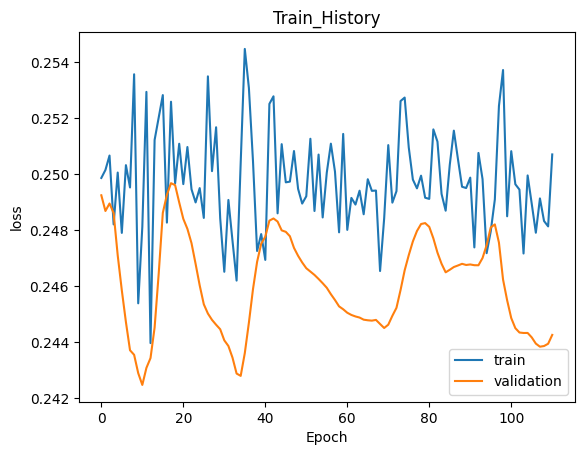

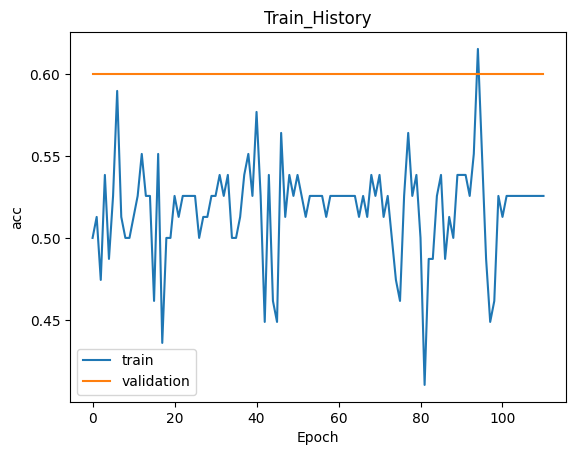

In [15]:
now_str = datetime.datetime.now()
now_str = datetime.datetime.strftime(now_str, '%Y%m%d_%H%M%S')

def show_train_history(train_history, train, validation):
    # 定義show_train_history函數，輸入下列參數:之前訓練過程所產生的train_history、
    # ...訓練資料的執行結果、驗證資料的執行結果
    print(train_history.history)
    plt.style.use('default')
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train_History')  # 顯示圖的標題
    plt.ylabel(train)  # 顯示y軸的標籤
    plt.xlabel('Epoch')  # 設定x軸標籤是'Epoch'
    plt.legend(['train', 'validation'], loc='best')
    # 設定國例是顯示'train', 'validation',位置在左上角

    train_history_path = os.path.join(now_path, 'train_history', Tr_ver)
    os.makedirs(train_history_path, exist_ok=True)

    plt.savefig(os.path.join(train_history_path, now_str + '_' + train + '.png'), bbox_inches='tight', pad_inches=0)

    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'acc', 'val_acc')
# show_train_history(train_history, 'accuracy', 'val_accuracy')

In [16]:
scores = model.evaluate(test_value_4D, test_label_OneHot)
print('loss=', scores[0], '\nacc=', scores[1])

f = open(os.path.join(now_path, 'train_history', 'train_history.txt'), 'a+')  # a+

content = f.read()
f.seek(0, 0)

f.write('\n' + '---------------------------------' + '\n')
f.write('\n' + '*****' + Tr_ver + '*****' + '\n')
f.write(now_str + '\n')
f.write('loss=' + '\n' + str(scores[0]) + '\n')
f.write('acc=' + '\n' + str(scores[1]))

f.write('\n' + content)
f.close()

35/35 [==============================] - 0s 486us/sample - loss: 0.2511 - acc: 0.5143
loss= 0.25109284690448214 
acc= 0.51428574


In [17]:
# 使用pd.crosstab建立混淆矩陣，輸入下列參數:
prediction = model.predict_classes(test_value_4D)
pd.crosstab(test_label,  # 測試資料數字影像的其實值
            prediction,  # 測試資料數字影像的預測結果
            rownames=['label'],  # 設定行的名稱是label
            colnames=['predict'])  # 設定列的名稱是predict

predict,0
label,
0,18
1,17


In [18]:
MWpath = os.path.join(now_path, '..\..', 'model_weight')
os.makedirs(MWpath, exist_ok=True)
Wver = now_path.split('\\')[-1]
model.save(os.path.join(MWpath, Tr_ver + 'SoundWeight_' + Wver + '_type2.h5'))